# Manipulating Time Series Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 3. Window Functions: Rolling & Expanding Metrics

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6291 entries, 2000-01-01 to 2017-03-31
Data columns (total 1 columns):
Ozone    6167 non-null float64
dtypes: float64(1)
memory usage: 98.3 KB
None


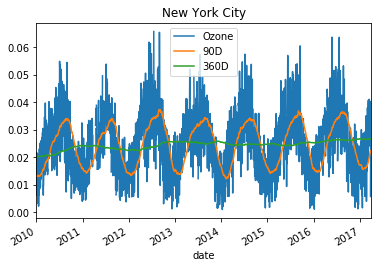

In [2]:
# Rolling average air quality since 2010 for new york city

data = pd.read_csv('data/air_quality/ozone_nyc.csv', parse_dates=['date'], index_col='date')
print(data.info())

# Calculate 90d and 360d rolling mean
data['90D'] = data.Ozone.rolling('90D').mean()
data['360D'] = data.Ozone.rolling('360D').mean()

# Plot data
data['2010':].plot(title='New York City')
plt.show()

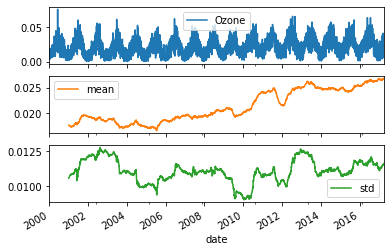

In [3]:
# Rolling 360-day median & std. deviation for nyc ozone data since 2000

data = pd.read_csv('data/air_quality/ozone_nyc.csv', parse_dates=['date'], index_col='date').dropna()

# Calculate the rolling mean and std
rolling_stats = data.Ozone.rolling(360).agg(['mean', 'std'])

# Join rolling_stats with ozone data
stats = data.join(rolling_stats)

# Plot stats
stats.plot(subplots=True);
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6300 entries, 2000-01-01 to 2017-03-31
Freq: D
Data columns (total 1 columns):
Ozone    6300 non-null float64
dtypes: float64(1)
memory usage: 98.4 KB


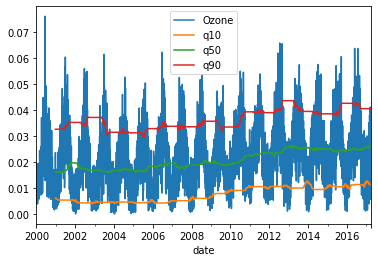

In [4]:
# Rolling quantiles for daily air quality in nyc

# Resample, interpolate and inspect ozone data
data = data.resample('D').interpolate()
data.info()

# Create the rolling window
rolling = data.rolling(360)['Ozone']

# Insert the rolling quantiles to the monthly returns
data['q10'] = rolling.quantile(.1)
data['q50'] = rolling.quantile(.5)
data['q90'] = rolling.quantile(.9)

# Plot the data
data.plot()
plt.show()

In [5]:
# Cumulative sum vs .diff()

# Calculate differences
differences = data.diff().dropna()

# Select start price
start_price = data.first('D')

# Calculate cumulative sum
cumulative_sum = start_price.append(differences).cumsum()

# Validate cumulative sum equals data
data.equals(cumulative_sum)

False

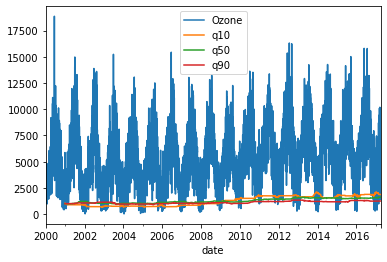

In [6]:
# Cumulative return on $1,000 invested in google vs apple I

# Define your investment
investment = 1000

# Calculate the daily returns here
returns = data.pct_change()

# Calculate the cumulative returns here
returns_plus_one = returns.add(1)
cumulative_return = returns_plus_one.cumprod()

# Calculate and plot the investment return here
cumulative_return.mul(investment).plot()
plt.show()

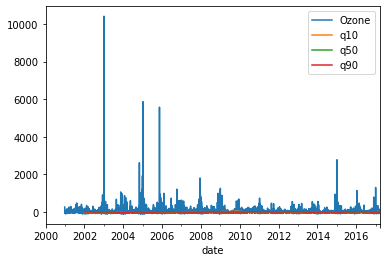

In [7]:
# Cumulative return on $1,000 invested in google vs apple II

import numpy as np

# Define a multi_period_return function
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1


# Calculate daily returns
daily_returns = data.pct_change()

# Calculate rolling_annual_returns
rolling_annual_returns = daily_returns.rolling('360D').apply(multi_period_return, raw=True)

# Plot rolling_annual_returns
rolling_annual_returns.mul(100).plot();
plt.show()

In [8]:
from numpy import random
import seaborn as sns

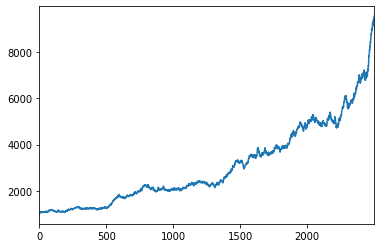

In [9]:
# Random walk
seed = 42

random_walk = random.normal(loc=.001, scale=0.01, size=2500)

# Convert random_walk to pd.series
random_walk = pd.Series(random_walk)

# Create random_prices
random_prices = random_walk.add(1).cumprod()
random_prices.mul(1000).plot()
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 6 columns):
AAPL    1761 non-null float64
AMGN    1761 non-null float64
AMZN    1761 non-null float64
CPRT    1761 non-null float64
EL      1761 non-null float64
GS      1761 non-null float64
dtypes: float64(6)
memory usage: 96.3 KB
None
          AAPL      AMGN      AMZN      CPRT        EL        GS
AAPL  1.000000  0.639423 -0.782640 -0.139609 -0.087176 -0.064160
AMGN  0.639423  1.000000 -0.267567 -0.484273  0.265609  0.174887
AMZN -0.782640 -0.267567  1.000000 -0.221807  0.157860  0.147352
CPRT -0.139609 -0.484273 -0.221807  1.000000 -0.141719  0.215925
EL   -0.087176  0.265609  0.157860 -0.141719  1.000000 -0.612696
GS   -0.064160  0.174887  0.147352  0.215925 -0.612696  1.000000


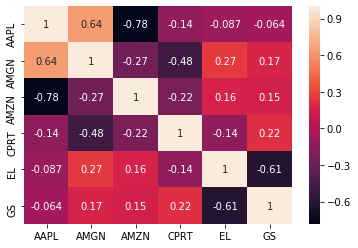

In [10]:
# Annual return correlations among several stocks

data = pd.read_csv('data/stock/stock_data.csv', parse_dates=['date'], index_col='date').dropna()
data = data.iloc[:, 0:6]
print(data.info())

# Calculate year-end prices
annual_prices = data.resample('A').last()

# Calculate annual returns
annual_returns = annual_prices.pct_change()

# Calculate the correlation matrix
correlations = annual_returns.corr()
print(correlations)

# Visualize the correlations as heatmap
sns.heatmap(correlations, annot=True)
plt.show()

## 4. Building a value-weighted index

In [11]:
# Explore and clean company listing information

all_stocks = pd.read_excel("data/stock/listings.xlsx",
                           sheet_name=['amex', 'nasdaq', 'nyse'])

listings = pd.DataFrame()
for df in all_stocks.values():
    print("Adding {} rows".format(df.shape[0]))
    listings = listings.append(df)

print(listings.shape, '\n')

print(listings.info())

Adding 360 rows
Adding 3167 rows
Adding 3147 rows
(6674, 7) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6674 entries, 0 to 3146
Data columns (total 7 columns):
Stock Symbol             6674 non-null object
Company Name             6674 non-null object
Last Sale                6590 non-null float64
Market Capitalization    6674 non-null float64
IPO Year                 2852 non-null float64
Sector                   5182 non-null object
Industry                 5182 non-null object
dtypes: float64(3), object(4)
memory usage: 417.1+ KB
None


In [12]:
# Move 'stock symbol' into the index
listings.set_index('Stock Symbol', inplace=True)

# Drop rows with missing 'sector' data
listings.dropna(subset=['Sector'], inplace=True)

# Select companies with IPO Year before 2019
listings = listings[listings['IPO Year'] < 2019]

# Inspect the new listings data
print(listings.info(), '\n')

# Show the number of companies per sector
print(listings.groupby('Sector').size().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 6 columns):
Company Name             2349 non-null object
Last Sale                2349 non-null float64
Market Capitalization    2349 non-null float64
IPO Year                 2349 non-null float64
Sector                   2349 non-null object
Industry                 2349 non-null object
dtypes: float64(3), object(3)
memory usage: 128.5+ KB
None 

Sector
Health Care              445
Consumer Services        402
Technology               386
Finance                  351
Energy                   144
Capital Goods            143
Public Utilities         104
Basic Industries         104
Consumer Non-Durables     89
Miscellaneous             68
Transportation            58
Consumer Durables         55
dtype: int64


In [13]:
# Select and inspect index components

# Select largest company for each sector
components = listings.groupby(['Sector'])['Market Capitalization'].nlargest(1)
print(components.sort_values(ascending=False), '\n')

# Select stock symbols and print the result
tickers = components.index.get_level_values('Stock Symbol')
print(tickers, '\n')

# Print company name, market cap, and last price for each component
info_cols = ['Company Name', 'Market Capitalization', 'Last Sale']
print(listings.loc[tickers, info_cols].sort_values('Market Capitalization', ascending=False))

Sector                 Stock Symbol
Technology             AAPL            7.400245e+11
Consumer Services      AMZN            4.221385e+11
Miscellaneous          BABA            2.755250e+11
Health Care            AMGN            1.189272e+11
Transportation         UPS             9.018089e+10
Finance                GS              8.884059e+10
Consumer Non-Durables  ABEV            8.824020e+10
Basic Industries       RIO             7.043148e+10
Public Utilities       TEF             5.460981e+10
Capital Goods          GM              5.008634e+10
Energy                 PAA             2.222300e+10
Consumer Durables      CPRT            1.362092e+10
Name: Market Capitalization, dtype: float64 

Index(['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF',
       'AAPL', 'UPS'],
      dtype='object', name='Stock Symbol') 

                                    Company Name  Market Capitalization  \
Stock Symbol                                                           

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
AAPL    1761 non-null float64
AMGN    1761 non-null float64
AMZN    1761 non-null float64
CPRT    1761 non-null float64
EL      1762 non-null float64
GS      1762 non-null float64
ILMN    1761 non-null float64
MA      1762 non-null float64
PAA     1762 non-null float64
RIO     1762 non-null float64
TEF     1762 non-null float64
UPS     1762 non-null float64
dtypes: float64(12)
memory usage: 179.0 KB
None


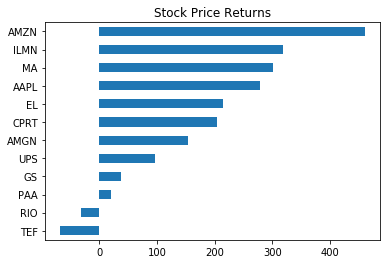

In [14]:
# Import index component price information

stock_prices = pd.read_csv('data/stock/stock_data.csv', parse_dates=['date'], index_col='date')
print(stock_prices.info())

# Calculate the returns
price_return = stock_prices.iloc[-1].div(stock_prices.iloc[0]).sub(1).mul(100)

# Plot horizontal bar chart of sorted price_return
price_return.sort_values().plot(kind='barh', title='Stock Price Returns')
plt.show()

In [15]:
# Build a market-cap weighted index

# Select components and relevant columns from listings
components = listings.loc[tickers, ['Market Capitalization', 'Last Sale']]
print(components.head(), '\n')

# Calculate the number of shares here
no_shares = components['Market Capitalization'].div(components['Last Sale'])
print(no_shares.sort_values(ascending=False))

              Market Capitalization  Last Sale
Stock Symbol                                  
RIO                    7.043148e+10      38.94
GM                     5.008634e+10      33.39
CPRT                   1.362092e+10      29.65
ABEV                   8.824020e+10       5.62
AMZN                   4.221385e+11     884.67 

Stock Symbol
ABEV    1.570110e+10
AAPL    5.246540e+09
TEF     5.037805e+09
BABA    2.500000e+09
RIO     1.808718e+09
GM      1.500040e+09
UPS     8.692972e+08
AMGN    7.358902e+08
PAA     7.234050e+08
AMZN    4.771706e+08
CPRT    4.593903e+08
GS      3.978174e+08
dtype: float64
